Setup

In [1]:
%%capture
!pip install transformers transformers[torch]

Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import Trainer, TrainingArguments
from transformers import pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device, torch.cuda.get_device_name(0)

(device(type='cuda'), 'NVIDIA GeForce RTX 3090')

In [4]:
df = pd.read_json("../_data/binary_topic.json")
df["title+text"] = df["title"] + " " + df["text"]

texts = df["title+text"].tolist()
labels = df["classification"].tolist()

df["classification"].value_counts().sort_index()

0    7647
1    6799
Name: classification, dtype: int64

In [5]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, stratify=labels, test_size=0.2
)

len(train_texts),len(test_texts)

(11556, 2890)

In [6]:
model_name = 'roberta-large'

tokenizer = RobertaTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [7]:
id2label = {0: "FIN", 1: "NONFIN"}
label2id = {"FIN": 0, "NONFIN": 1}

model = RobertaForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=2,
    id2label=id2label, 
    label2id=label2id
)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should 

In [8]:
train_encodings = tokenizer(train_texts, truncation=True, max_length=512)

In [9]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [10]:
train_dataset = SentimentDataset(train_encodings, train_labels)

In [11]:
training_args = TrainingArguments(
    output_dir='./results',
    save_strategy="no",
    optim="adamw_torch",
    learning_rate=2e-5,
    num_train_epochs=4, 
    group_by_length=True,
    do_eval=False,
    evaluation_strategy="no",
    per_device_train_batch_size=8, 
    per_device_eval_batch_size=8,  
    warmup_steps=100,               
    weight_decay=0.01,              
    logging_strategy="no",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,                        
    args=training_args,                 
    train_dataset=train_dataset,        
    tokenizer=tokenizer,
    data_collator=data_collator, #eig. automatisch, da tokenizer arg gegeben
)

In [12]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=5780, training_loss=0.19964411646437066, metrics={'train_runtime': 2882.9607, 'train_samples_per_second': 16.034, 'train_steps_per_second': 2.005, 'total_flos': 3.397681960989389e+16, 'train_loss': 0.19964411646437066, 'epoch': 4.0})

In [13]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)
test_dataset = SentimentDataset(test_encodings, test_labels)

raw_output = trainer.predict(test_dataset)
y_preds = np.argmax(raw_output.predictions, axis=-1)
accuracy_score(y_true=test_labels, y_pred=y_preds)

0.9325259515570934

In [14]:
accuracy = accuracy_score(test_labels, y_preds)
precision = precision_score(test_labels, y_preds)
recall = recall_score(test_labels, y_preds)
f1 = f1_score(test_labels, y_preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9325259515570934
Precision: 0.9416224412433661
Recall: 0.913235294117647
F1-score: 0.9272116461366181


In [15]:
report = classification_report(test_labels, y_preds)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      1530
           1       0.94      0.91      0.93      1360

    accuracy                           0.93      2890
   macro avg       0.93      0.93      0.93      2890
weighted avg       0.93      0.93      0.93      2890



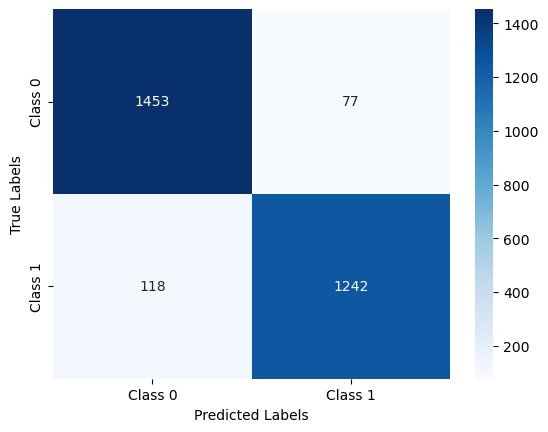

In [16]:
cm = confusion_matrix(test_labels, y_preds)
xlabels = ['Class 0', 'Class 1']
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=xlabels, yticklabels=xlabels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [17]:
trainer.save_model('./results/roberta_large_topic')

In [20]:
model_path = './results/roberta_large_topic'
model = RobertaForSequenceClassification.from_pretrained(model_path, num_labels=2)
test_trainer = Trainer(model)
raw_predictions = test_trainer.predict(test_dataset)
y_preds = np.argmax(raw_predictions.predictions, axis=-1)
accuracy_score(y_true=test_labels, y_pred=y_preds)

0.9325259515570934

In [21]:
texts = [
        """US economic growth was stronger than previously reported at the start of the year.""",
        """Tottenham Hotspur have completed and confirmed the signing of James Maddison from Leicester City.""",
        ]

classifier = pipeline("text-classification", model='./results/roberta_large_topic', device=0)
classifier(texts)

[{'label': 'FIN', 'score': 0.999653697013855},
 {'label': 'NONFIN', 'score': 0.999811589717865}]